In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pingouin as pg
import statsmodels.api as sm

In [3]:
email = pd.read_csv('email/email_table.csv')
email_opened = pd.read_csv('email/email_opened_table.csv')
link_clicked = pd.read_csv('email/link_clicked_table.csv')

In [4]:
# email_opened=email_opened.merge(email,left_on='email_id',right_on='email_id',how='left')
# link_clicked=link_clicked.merge(email,left_on='email_id',right_on='email_id',how='left')

In [5]:
print('percentage of users opened the email: %.2f'%(email_opened.shape[0]/email.shape[0]*100),'%')
print('percentage of users clicked the link: %.2f'%(link_clicked.shape[0]/email.shape[0]*100),'%')

percentage of users opened the email: 10.35 %
percentage of users clicked the link: 2.12 %


# click link


In [6]:
email['link_clicked'] = email['email_id'].agg(lambda x: 1 if x in link_clicked['email_id'].to_list() else 0)
email = pd.get_dummies(email,drop_first=True)

In [7]:
email['intercept'] = 1
logit=sm.Logit(email.link_clicked,email.drop('link_clicked',axis=1))
output = logit.fit()

Optimization terminated successfully.
         Current function value: 0.094930
         Iterations 9


In [93]:
output_table=pd.DataFrame(dict(coefficients=output.params,SE=output.bse,z=output.tvalues,p_values=output.pvalues))
output_table[output_table.p_values <= 0.05]

,coefficients,SE,z,p_values
hour,0.016792,0.004944,3.396387,6.828168e-04
user_past_purchases,0.183822,0.005672,32.410134,1.975787e-230
email_text_short_email,0.267303,0.044721,5.977168,2.270500e-09
email_version_personalized,0.610270,0.046169,13.218056,6.902455e-40
weekday_Monday,0.493962,0.091356,5.406972,6.409898e-08
weekday_Saturday,0.239995,0.095666,2.508669,1.211869e-02
weekday_Thursday,0.570977,0.090386,6.317124,2.664760e-10
weekday_Tuesday,0.571331,0.090280,6.328405,2.477091e-10
weekday_Wednesday,0.707766,0.088769,7.973150,1.546800e-15
user_country_UK,1.139571,0.119947,9.500642,2.085993e-21


In [94]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

In [97]:
data = pd.read_csv('https://drive.google.com/uc?export=download&id=1PXjbqSMu__d_ppEv92i_Gnx3kKgfvhFk') 
data_dummy = pd.get_dummies(data, drop_first=True) 
train_cols = data_dummy.drop('clicked', axis=1)

In [99]:
tree = DecisionTreeClassifier(max_depth=4,class_weight='balanced',min_impurity_decrease=0.001)
tree.fit(train_cols,data_dummy['clicked'])
export_graphviz(tree,feature_names=train_cols.columns,proportion=True,rotate=True,out_file='tree_case_2.dot')
Source.from_file('tree_case_2.dot')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [258]:
tree = DecisionTreeClassifier(max_depth=4,min_impurity_decrease=0.001)
tree.fit(train_cols,data_dummy['clicked'])
export_graphviz(tree,feature_names=train_cols.columns,proportion=True,rotate=True,out_file='tree_case_2.dot')
Source.from_file('tree_case_2.dot')

ValueError: The only valid preset for class_weight is "balanced". Given "auto".

# partial dependency plot

In [116]:
from pdpbox import pdp, info_plots
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence

In [112]:
np.random.seed(123)
rf = RandomForestClassifier(n_estimators=50,oob_score=True,class_weight={0:0.05,1:0.95})
rf.fit(train_cols,data_dummy.clicked)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.05, 1: 0.95}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

In [115]:
print('the accuracy is:',rf.oob_score_)

the accuracy is: 0.9775687843921961


[Text(0, 0, 'generic'), Text(0, 0, 'personalize')]

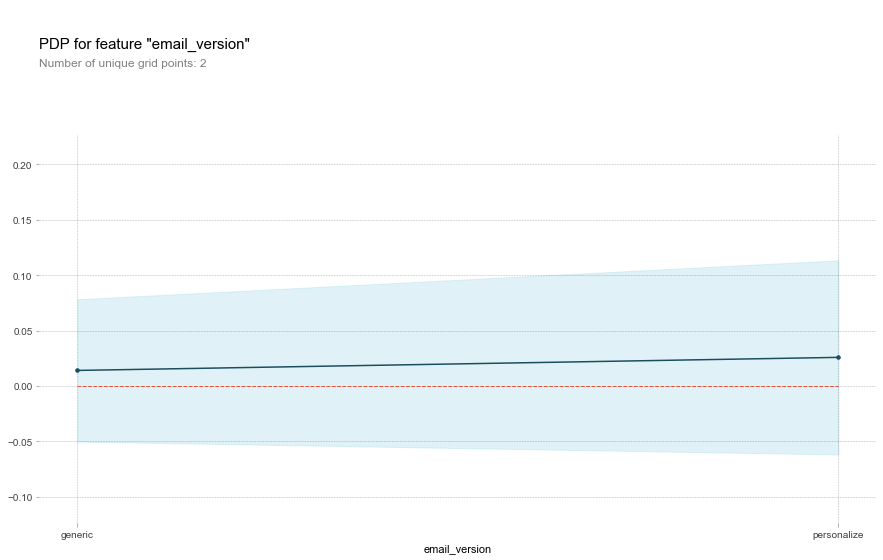

In [139]:
personalize_pdp_out=pdp.pdp_isolate(model=rf,dataset=train_cols,model_features=train_cols.columns,feature='email_version_personalized')
fig,axes = pdp.pdp_plot(personalize_pdp_out,feature_name='email_version',center=False)
axes['pdp_ax'].set_xticklabels(['generic','personalize'])

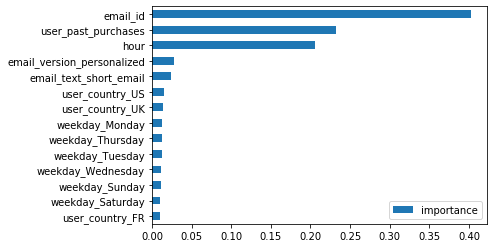

In [159]:
pd.DataFrame(dict(importance=rf.feature_importances_),index=train_cols.columns).sort_values(by='importance').plot(kind='barh')

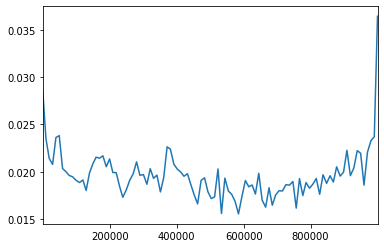

In [183]:
id_pdp = pdp.pdp_isolate(model=rf,feature='email_id',dataset=train_cols,model_features=train_cols.columns,num_grid_points=100)
pdp_dataset = pd.Series(id_pdp.pdp, index=id_pdp.feature_grids)
pdp_dataset.plot()

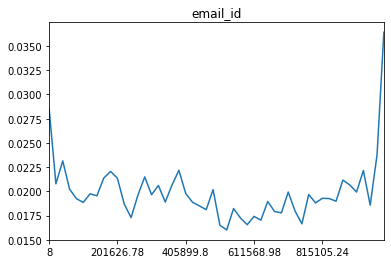

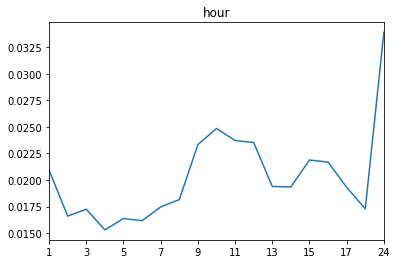

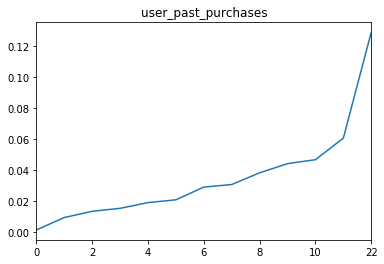

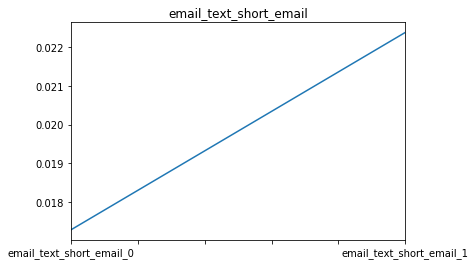

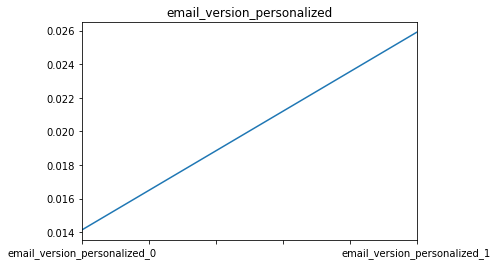

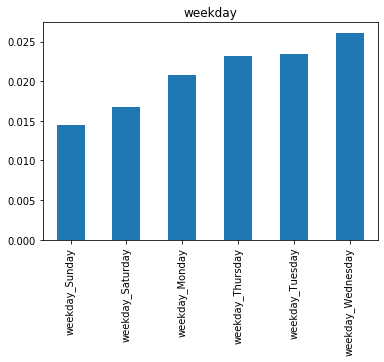

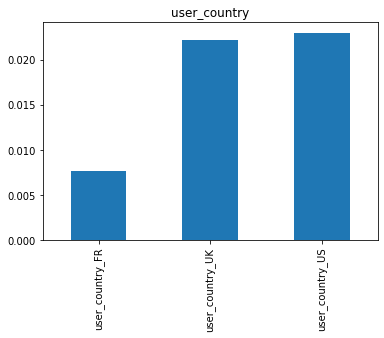

<Figure size 432x288 with 0 Axes>

In [255]:
columns = train_cols.columns.to_list()
columns_used = []
for variable in columns:
    plt.clf()
    cur_variable = [x for x in train_cols.columns if x.rsplit('_',1)[0] == variable.rsplit('_',1)[0] and x not in columns_used]
    columns_used += cur_variable
    if cur_variable != []:
        if len(cur_variable) == 1:
            pdp_iso = pdp.pdp_isolate(model=rf, dataset=train_cols, model_features=train_cols.columns, feature=cur_variable[0], num_grid_points=50)
            pd.Series(pdp_iso.pdp,index=pdp_iso.display_columns).plot(kind='line')
            plt.title(cur_variable[0])
        else:
            pdp_iso = pdp.pdp_isolate(model=rf, dataset=train_cols, model_features=train_cols.columns, feature=cur_variable, num_grid_points=50)
            pd.Series(pdp_iso.pdp,index=pdp_iso.display_columns).sort_values().plot(kind='bar')
            plt.title(cur_variable[0].rsplit('_',1)[0])
        plt.show()
#     plot_partial_dependence(estimator=rf,X=train_cols,features=cur_variable,feature_names=train_cols.columns)
    
        

In [228]:
pdp_iso = pdp.pdp_isolate(model=rf, dataset=train_cols, model_features=train_cols.columns, feature='hour', num_grid_points=50)

In [254]:
columns = train_cols.columns.to_list()
columns_used = []
for variable in columns:
    plt.clf()
    cur_variable = [e for e in columns if e.rsplit('_',1)[0] == variable.rsplit('_',1)[0] and e not in columns_used]
#     cur_variable += [x for x in train_cols.columns if x.rsplit('_',1)[0] == variable.rsplit('_',1)[0]]
    print(cur_variable)
    columns_used += cur_variable
#     for c in cur_variable:
#         columns.remove(c)
print(columns)

['email_id']
['hour']
['user_past_purchases']
['email_text_short_email']
['email_version_personalized']
['weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday']
[]
[]
[]
[]
[]
['user_country_FR', 'user_country_UK', 'user_country_US']
[]
[]
['email_id', 'hour', 'user_past_purchases', 'email_text_short_email', 'email_version_personalized', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'user_country_FR', 'user_country_UK', 'user_country_US']


<Figure size 432x288 with 0 Axes>

# Rulefit 

In [18]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from rulefit import RuleFit

In [19]:
np.random.seed(4686)
data = pd.read_csv('https://drive.google.com/uc?export=download&id=1PXjbqSMu__d_ppEv92i_Gnx3kKgfvhFk')
data = pd.get_dummies(data,drop_first=True)
# data['intercept'] = 1
X = data.drop('clicked',axis=1)
y = data['clicked']
rf = RandomForestClassifier(max_depth=2, n_estimators=10, class_weight={0:0.05,1:0.95})
rufi = RuleFit(rfmode='classify',tree_generator=rf,exp_rand_tree_size=False,lin_standardise=False)
rufi.fit(X.values,y.values,feature_names = X.columns)
X_new = np.concatenate((X, rufi.transform(X.values)),axis=1)


In [20]:
log = LogisticRegression(penalty='l1',solver='liblinear',C=0.1)
log.fit(X_new,y)
output = rufi.get_rules()
output.iloc[:,2] = np.transpose(log.coef_)

In [21]:
output[output.coef != 0].sort_values('coef',ascending=False)

,rule,type,coef,support,importance
12,user_country_UK,linear,8.636993e-01,1.000000,0.000000
10,weekday_Wednesday,linear,4.792413e-01,1.000000,0.000000
9,weekday_Tuesday,linear,3.378769e-01,1.000000,0.000000
5,weekday_Monday,linear,2.608226e-01,1.000000,0.000000
8,weekday_Thursday,linear,2.557927e-01,1.000000,0.000000
2,user_past_purchases,linear,1.737295e-01,1.000000,0.000000
25,user_country_US > 0.5 & weekday_Thursday > 0.5,rule,1.263357e-01,0.086879,0.000000
46,user_past_purchases > 3.5 & email_version_pers...,rule,1.126580e-01,0.235083,0.000000
34,email_version_personalized > 0.5 & user_countr...,rule,8.696946e-02,0.299828,0.000000
19,user_past_purchases <= 5.5 & email_version_per...,rule,4.369227e-02,0.360711,0.000000


# email_open

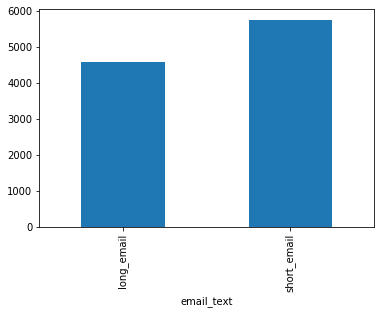

In [80]:
email_opened.groupby('email_text').size().plot(kind='bar')

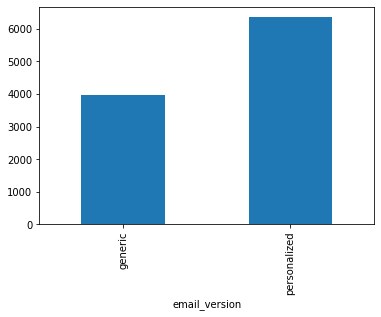

In [82]:
email_opened.groupby('email_version').size().plot(kind='bar')

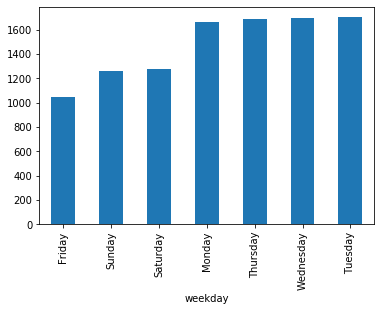

In [87]:
email_opened.groupby('weekday').size().sort_values().plot(kind='bar')

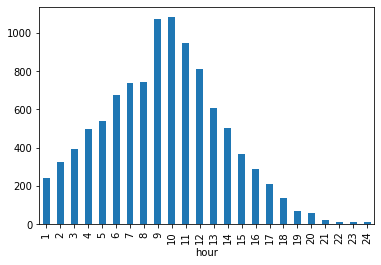

In [85]:
email_opened.groupby('hour').size().plot(kind='bar')

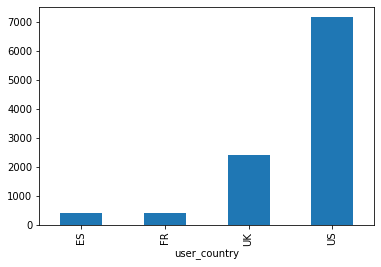

In [84]:
email_opened.groupby('user_country').size().plot(kind='bar')

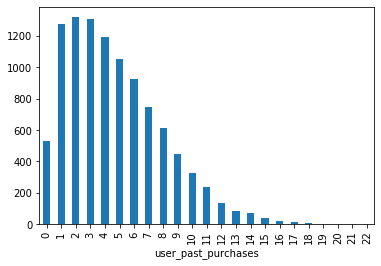

In [86]:
email_opened.groupby('user_past_purchases').size().plot(kind='bar')

# some quick observations:

+ short emails perform better than long emails interms of opened number

+ more personalized version emails are opened

+ more emails are opened during weekdays compared with weekends

+ more email (sent in the morning) are opened

+ the site may be a US basef website or the email is in English since the open rate for these two country are significantly high than the rest two

+ more email are opened by the user with less past purchases


In [ ]:
X_train, X_test, y_train, y_test = train_test_split()

In [11]:
email

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6
...,...,...,...,...,...,...,...
99995,803504,short_email,personalized,4,Monday,US,5
99996,899722,long_email,personalized,7,Saturday,US,1
99997,449610,long_email,personalized,11,Saturday,UK,6
99998,72497,short_email,generic,10,Monday,UK,0


In [40]:
X_train, X_test, y_train,y_test = train_test_split(email.drop('link_clicked'),email.link_clicked,random)

,email_id,hour,user_past_purchases,link_clicked,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US
0,85120,2,5,0,1,1,0,0,1,0,0,0,0,0,1
1,966622,12,2,1,0,1,0,0,1,0,0,0,0,1,0
2,777221,11,2,0,0,1,0,0,0,0,0,1,0,0,1
3,493711,6,1,0,1,0,1,0,0,0,0,0,0,1,0
4,106887,14,6,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,803504,4,5,0,1,1,1,0,0,0,0,0,0,0,1
99996,899722,7,1,0,0,1,0,1,0,0,0,0,0,0,1
99997,449610,11,6,0,0,1,0,1,0,0,0,0,0,1,0
99998,72497,10,0,0,1,0,1,0,0,0,0,0,0,1,0
